In [1]:
import tensorflow as tf 
from tensorflow.keras import datasets, layers, models

BATCH_SIZE = 100

def load_image(img_path, size = (32, 32)):
    label = tf.constant(1, tf.int8) if tf.strings.regex_full_match(img_path, ".*automobile.*") \
            else tf.constant(0, tf.int8)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img) # 注意此处为jpeg格式
    img = tf.image.resize(img, size) / 255.0
    return(img, label)

In [2]:
# 使用并行化预处理 num_parallel_calls 和预存数据 prefetch 来提升性能
ds_train = tf.data.Dataset.list_files("./data/cifar2/train/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .shuffle(buffer_size=1000).batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)

ds_test = tf.data.Dataset.list_files("./data/cifar2/test/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)

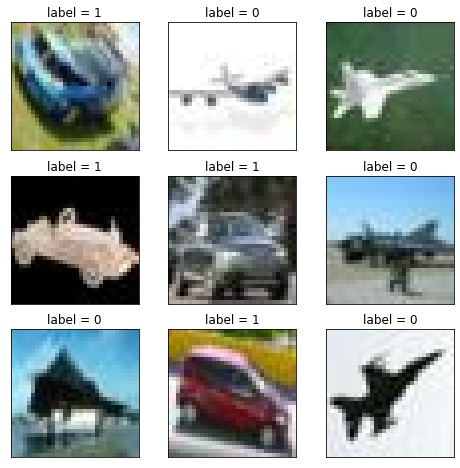

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'

# 查看部分样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8, 8)) 
for i, (img, label) in enumerate(ds_train.unbatch().take(9)):
    ax = plt.subplot(3, 3, i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 

In [4]:
for x, y in ds_train.take(1):
    print(x.shape, y.shape)

(100, 32, 32, 3) (100,)


In [5]:
tf.keras.backend.clear_session() # 清空会话

inputs = layers.Input(shape=(32, 32, 3), name="input")
x = layers.Conv2D(32, kernel_size=(3, 3), name="conv2d_1")(inputs)
x = layers.MaxPool2D(name="max_pooling2d_1")(x)
x = layers.Conv2D(64, kernel_size=(5, 5), name="conv2d_2")(x)
x = layers.MaxPool2D(name="max_pooling2d_2")(x)
x = layers.Dropout(rate=0.1, name="dropout")(x)
x = layers.Flatten(name="flatten")(x)
x = layers.Dense(32, activation='relu', name="danse")(x)
outputs = layers.Dense(1, activation='sigmoid', name="output")(x)

model = models.Model(inputs=inputs, outputs=outputs, name="model")

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0     

In [6]:
# import os
import datetime
from pathlib import Path

stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = str(Path('./data/autograph/' + stamp))

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.binary_crossentropy,
    metrics=["accuracy"]
)

history = model.fit(ds_train, epochs=10, validation_data=ds_test,
                    callbacks=[tensorboard_callback], workers=4)

Epoch 1/10
  1/100 [..............................] - ETA: 0s - loss: 0.7099 - accuracy: 0.4400WARNING:tensorflow:From /Users/FDUHYJ/anaconda3/envs/lisa/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
100/100 [==============================] - 11s 110ms/step - loss: 0.4490 - accuracy: 0.7866 - val_loss: 0.3313 - val_accuracy: 0.8640
Epoch 2/10
100/100 [==============================] - 13s 129ms/step - loss: 0.3314 - accuracy: 0.8556 - val_loss: 0.2631 - val_accuracy: 0.8880
Epoch 3/10
100/100 [==============================] - 13s 132ms/step - loss: 0.2700 - accuracy: 0.8842 - val_loss: 0.2181 - val_accuracy: 0.9090
Epoch 4/10
100/100 [==============================] - 11s 105ms/step - loss: 0.2348 - accuracy: 0.9054 - val_loss: 0.2025 - val_accuracy: 0.9200
Epoch 5/10
100/100 [===============

In [11]:
%load_ext tensorboard
%tensorboard --logdir ./data/autograph/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [12]:
from tensorboard import notebook
notebook.list()

Known TensorBoard instances:
  - port 6006: logdir ./data/autograph/ (started 0:00:03 ago; pid 36334)


In [13]:
# 在 tensorboard 中查看模型
notebook.start("--logdir ./data/autograph/")

Reusing TensorBoard on port 6006 (pid 36334), started 0:16:55 ago. (Use '!kill 36334' to kill it.)

In [14]:
import pandas as pd 
dfhistory = pd.DataFrame(history.history)
dfhistory.index = range(1, len(dfhistory) + 1)
dfhistory.index.name = 'epoch'

dfhistory

,loss,accuracy,val_loss,val_accuracy
epoch,,,,
1,0.449009,0.7866,0.331269,0.8640
2,0.331418,0.8556,0.263134,0.8880
3,0.270019,0.8842,0.218141,0.9090
4,0.234814,0.9054,0.202480,0.9200
5,0.202122,0.9176,0.199820,0.9275
6,0.182991,0.9285,0.177118,0.9300
7,0.161947,0.9374,0.172488,0.9315
8,0.140671,0.9448,0.170727,0.9380
9,0.126156,0.9496,0.160099,0.9410


In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_' + metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_" + metric, 'val_' + metric])
    # plt.show()

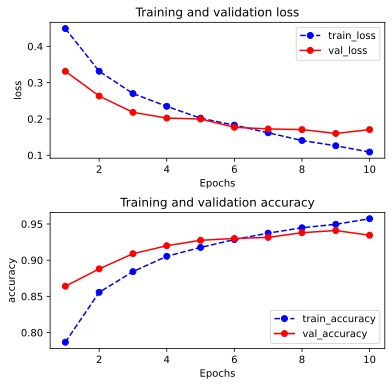

In [18]:
plt.figure(figsize=(6, 6))
plt.subplots_adjust(hspace=0.4)     # 适当调整一下子图之间的纵间距
plt.subplot(2, 1, 1)
plot_metric(history, "loss")
plt.subplot(2, 1, 2)
plot_metric(history, "accuracy")

In [19]:
# 可以使用evaluate对数据进行评估
val_loss, val_accuracy = model.evaluate(ds_test, workers=4)
print(val_loss, val_accuracy)

20/20 [==============================] - 1s 35ms/step - loss: 0.1706 - accuracy: 0.9345
0.17062519490718842 0.934499979019165


In [20]:
model.predict(ds_test)

array([[0.9996369 ],
       [0.99610496],
       [0.9995226 ],
       ...,
       [0.9983187 ],
       [0.1212841 ],
       [0.99217534]], dtype=float32)

In [21]:
for x,y in ds_test.take(1):
    print(model.predict_on_batch(x[0:20]))

[[2.89505213e-01]
 [1.35202135e-05]
 [7.44611025e-04]
 [6.99073076e-04]
 [7.29461432e-01]
 [8.14574232e-05]
 [9.98318672e-01]
 [5.59424162e-02]
 [7.05548446e-05]
 [2.00748444e-04]
 [1.61284208e-03]
 [2.72640586e-03]
 [3.89826528e-06]
 [3.22553247e-01]
 [2.03045905e-02]
 [9.98455346e-01]
 [9.96827304e-01]
 [7.45079815e-02]
 [9.55962539e-02]
 [9.99922097e-01]]


In [22]:
# 保存权重，该方式仅仅保存权重张量
model.save_weights('./data/tf_model_weights.ckpt', save_format="tf")

In [23]:
# 保存模型结构与模型参数到文件,该方式保存的模型具有跨平台性便于部署
model.save('./data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

model_loaded = tf.keras.models.load_model('./data/tf_model_savedmodel')
model_loaded.evaluate(ds_test)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./data/tf_model_savedmodel/assets
export saved model.
20/20 [==============================] - 1s 33ms/step - loss: 0.1706 - accuracy: 0.9345


[0.17062519490718842, 0.934499979019165]